# TensorFlow Probability Distributions  
### Day 1/100 Days Of TensorFlow Probability  

Today is Day 1 of my 100 Days of TensorFlow Probability! Today, I am going to explore distributions. This is going to be a slow start - all I want to do is to sample from distributions. Nothing fancy, but the foundation of probabilistic programming, so it seems like a good place to start.

I am going to pick & choose parts of the TFP Examples. Specifically:  

  - https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/A_Tour_of_TensorFlow_Probability.ipynb  
  - https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Distributions_Tutorial.ipynb  
  - https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb  
  
Note, that I am going to do this in Google Colab, which is already setup with tensorflow and tensorflow probability. Let's get cracking.

In [0]:
import collections

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

### Univariate Sampling Distributions  

It's really easy to sample from univariate distributions. If you have ever done this in numpy or R, then this will look really familiar to you. The only difference, is that TFP is object oriented - so first, we will instantiate a distribution to sample from, then we will call the sample method.

For example, here is a sample from a normal distribution with $\mu = 3, \sigma = 2$:

In [12]:
# instantiate our distribution
gaussian = tfd.Normal(loc = 3.0, scale = 2.0)

# sample...
for x in range(10):
  print("Sample {} from our gaussian: \t{:.2f}".format(x, gaussian.sample()))

Sample 0 from our gaussian: 	2.45
Sample 1 from our gaussian: 	2.30
Sample 2 from our gaussian: 	3.57
Sample 3 from our gaussian: 	-0.87
Sample 4 from our gaussian: 	1.07
Sample 5 from our gaussian: 	2.25
Sample 6 from our gaussian: 	2.98
Sample 7 from our gaussian: 	-0.36
Sample 8 from our gaussian: 	8.83
Sample 9 from our gaussian: 	2.60


Of course, we can simulate (sample) from this distribution *en masse* and plot the results:

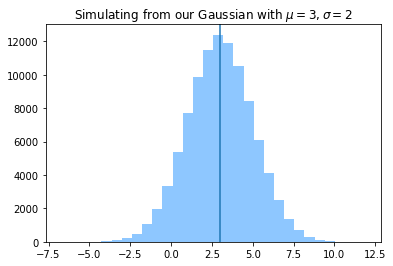

In [24]:
xs = gaussian.sample(100000)

plt.hist(xs, bins=30, color='dodgerblue', alpha=0.5)
plt.axvline(x = 3.0)
plt.title("Simulating from our Gaussian with $\mu = 3, \sigma=2$")
plt.show()

So far so good - just like numpy or R. I'm happy with that. 


### "Stacking Simulations"

Let's get a little more creative and start to combine distributions together. First, let's sample a rate from a Gamma distribution and then use this rate to simulate from a Poisson distribution. We'll begin by sampling a rate from the Gamma:

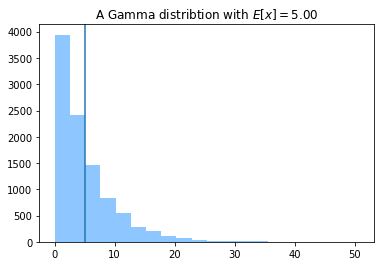

In [47]:
rv_gamma = tfd.Gamma(concentration = 1.0, rate = 1.0 / 5.0)
simulation = rv_gamma.sample(10000)

plt.hist(simulation, bins=20, color='dodgerblue', alpha=.5)
plt.axvline(x = rv_gamma.mean().numpy())
plt.title("A Gamma distribtion with $E[x] = {:1.2f}$".format(rv_gamma.mean()))
plt.show()


There are a couple of points in the above code which I want to highlight. First, notice that I have included a prefix of `rv_` to the Gamma object. This stands for "random variable", i.e. this object is a random variable which is drawn from a Gamma distribution. This seems to be a coding standard in the tfp world.

Second, notice that I have used the `.mean()` method of our random variable. These being objects, there are a bunch of methods which we can call on for example: mean, median, stddev, log_prob, entropy...

Finally, the samples which we drew and stored in the variable `simulation` are a tensor. Similarly, the `.mean()` method also returns a tensor. Matplotlib will throw an error if you try to pass this tensor directly into the `plt.axvline()` call. This is why we used the `.numpy()` method to extract the data value from the tensor.


I'm starting to feel a little more comfortable with this now. So let's extend this. Let us assume that we have a bunch of count data which is Poisson distributed with a known rate. Simulating from this would give us a good approximation of our data:

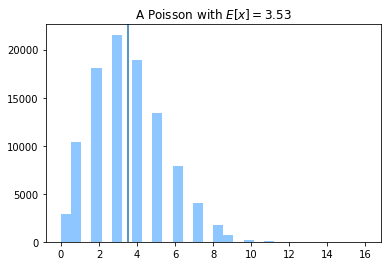

In [53]:
lambda_ = rv_gamma.sample()
rv_poisson = tfd.Poisson(lambda_)

plt.hist(rv_poisson.sample(100000), bins=30, color='dodgerblue', alpha=.5)
plt.axvline(x = lambda_.numpy())
plt.title("A Poisson with $E[x] = {:1.2f}$".format(lambda_))
plt.show()

Depending on the random draw, the expected value above is unlikely to be exactly 5 (the rate we defined for the Gamma). This is because the sampled rate, `lambda_`, is an indpedent draw from our Gamma. If we were to draw many samples from our Gamma, the expected value would eventually converge to 5, but we would also get a sense of the variability of this random variable.

This is closer to the real world. It is rare that we would know everything about our process. For example, we are all comfortable that people are different heights and that is we randomly measured people, there would be variability in those measured heights. However, most of us (naively) assume that the mean value is a real, fixed, unvarying amount. Concretely, most people are happy to say that "people are of varying heights", but they would be less comfortable with the idea that "the average height" is also a varying quantity...

It's an important concept. Think of a business intelligence dashboard and classic "analytics" where we report summary stats, like the mean. Very, very few business people would be comfortable with the idea that the mean itself has uncertainty associated with it.

The good news, is that we can simulate this. Let's go back to our Poisson simulation and instead of drawing a *single rate from `rv_gamma`*, let's draw a range of rates from this distribution and pass all of these to our Poisson simulation. This way, we will get a better sense for the true variability.


We will do this below. First however, I am going to adjust our Gamma distribution slightly so that it is centered more strongly around 5 (let us assume that the true rate is close to this value):

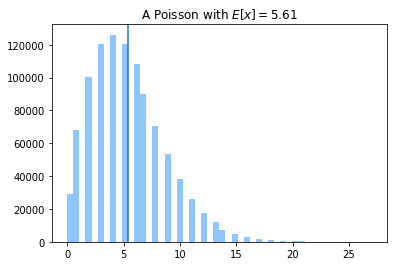

In [97]:

rv_gamma2 = tfd.Gamma(5., 1.)
lambdas_ = rv_gamma2.sample(100)
rv_poisson = tfd.Poisson(lambdas_)

plt.hist(rv_poisson.sample(10000).numpy().ravel(), bins=50, color='dodgerblue', alpha=.5)
plt.axvline(x = rv_poisson.sample().numpy().mean())
plt.title("A Poisson with $E[x] = {:1.2f}$".format(rv_poisson.sample().numpy().mean()))
plt.show()

This is a truer picture of our "poisson process". Notice that we have a slightly higher amount of variability and values >10 are much more likely in this second simulation than they were in our first simulation. This is a very "real world" type of phenomenon.

### Unpacking our "stacked simulation"  

It's probably worth taking a moment or two to inspect our two simulations above: the simulation from the gamma distribution and the simulation from the poisson.

The concept of "shape" is central to tensorflow and has been adopted by tensorflow probability. When we sample from the gamma distribution, we get a tensor where `shape = (n_samples,)`. Here is an example with 5 samples drawn from our gamma distribution:

In [98]:
rates = rv_gamma2.sample(5)
rates

<tf.Tensor: id=4537, shape=(5,), dtype=float32, numpy=
array([5.096189 , 2.4959877, 3.958752 , 3.8258288, 1.0565171],
      dtype=float32)>

Similarly, if we draw three samples from our Poisson, we get a shape of `(3,)`:

In [100]:
rv_poisson = tfd.Poisson(rv_gamma2.sample())
counts = rv_poisson.sample(3)
counts

<tf.Tensor: id=4588, shape=(3,), dtype=float32, numpy=array([ 4.,  9., 10.], dtype=float32)>

Notice above, that I have reinstantiated the Poisson distribution with a *single draw from the Gamma*. This single draw has aa shape of `(1,)` and when we pass this to our Poisson distribution, the result is that our Poisson distribution will have this shape.

If however, we pass in our rates which are of shape `(5,)`, then our Poisson distribution will also have a shape of `(5,)`. You can think of this as 5 separate Poisson distributions. Then, when we ask for 3 samples from our Poisson, we actually get 15 (3 samples from each of our 5 different Poissons):

In [101]:
rv_poisson = tfd.Poisson(rv_gamma2.sample(5))
rv_poisson

<tfp.distributions.Poisson 'Poisson/' batch_shape=[5] event_shape=[] dtype=float32>

In [102]:
counts = rv_poisson.sample(3)
counts

<tf.Tensor: id=4625, shape=(3, 5), dtype=float32, numpy=
array([[ 4.,  3.,  4., 11.,  3.],
       [ 3.,  5.,  3.,  9.,  1.],
       [ 3.,  3.,  4.,  7.,  2.]], dtype=float32)>

Distributions & their shapes are explained (at length...) in this tutorial notebook: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb  

I think this will do for Day One.